In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import helpers
import stx as stx
import utils as ut

In [16]:
# Start by loading the data

cnt_pth ="../data/Allen-2/Allen-2-count-matrix.tsv.gz" # count data
img_pth = "../data/Allen-2/tissue_hires_image.png" # HE-image
jsn_pth = "../data/Allen-2/scalefactors_json.json" #json file with additional info
mta_pth = "../data/Allen-2/allen-2-meta.tsv"

# For ease of usage an STdata class has
# been implemented, providing the some
# basic features for data handling

data = stx.STdata(cnt = cnt_pth,
                  img = img_pth,
                  mta = mta_pth,
                  scf = jsn_pth,
                  )

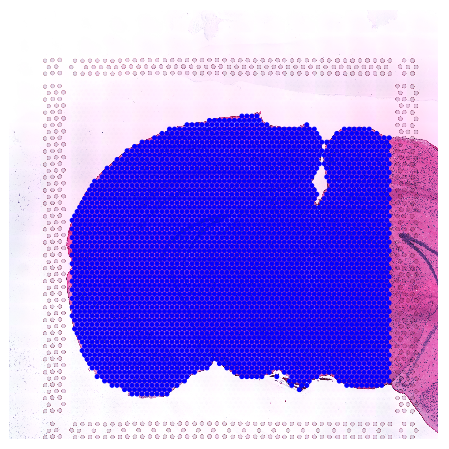

In [4]:
# Our Visium section looks as follows
data.plot(figsize = (8,8))
plt.show()

Index(['region'], dtype='object')


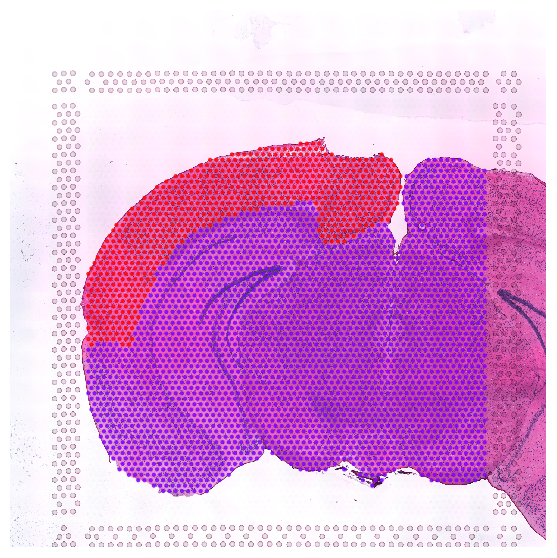

In [29]:
# Our meta data provides a (rather sloppy)
# annotation of isocortex spots

data.set_foi('region')
data.plot(cmap = plt.cm.rainbow,
          figsize = (10,10),
          marker_size = 10,
          alpha = 0.8)
plt.show()

In [63]:
# Looking more specifically at the isocortex
%matplotlib inline

# For an initial quick analysis we could also
# cluster the expression data. 

np.random.seed(1337)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
import umap

n_clusters = 10

dimred = FastICA(n_components = 20)
km = KMeans(n_clusters = n_clusters)

# Select only isocortex spots
sel = data.mta['region'].values.flatten() == 1
# First we normalize the data
ncnt = stx.normalize_cnt(data.cnt.iloc[sel,:])
# Project data to a 20 dim space
ncnt = dimred.fit_transform(ncnt)
# Cluster the data
cidx = km.fit_predict(ncnt)
# Project into 2 dim space for visualization
umap_crd = umap.UMAP().fit_transform(ncnt)



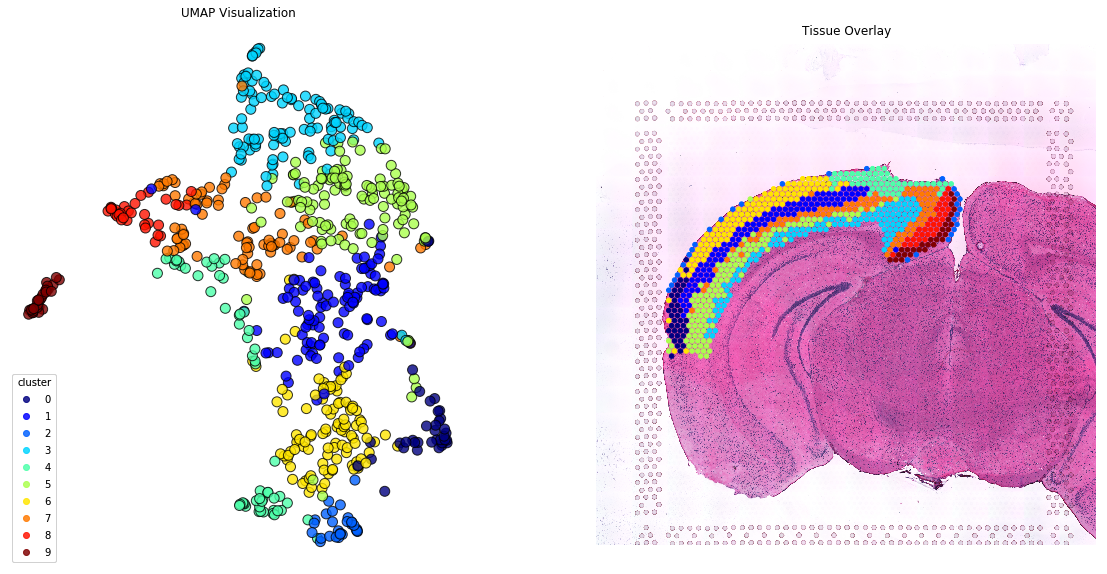

In [81]:
cmap = plt.cm.jet
labels = list(map(lambda x: 'cluster ' + str(x),range(n_clusters)))
fig, ax = plt.subplots(1,2,figsize = (20,10))


sct = ax[0].scatter(umap_crd[:,0],
              umap_crd[:,1],
              c = cidx,
              cmap = cmap,
              edgecolor = 'black',
              alpha = 0.8,
              s= 100,
            )

legend = ax[0].legend(*sct.legend_elements(),
                    loc="lower left",
                    title="cluster")

ax[0].add_artist(legend)
ax[0].set_title("UMAP Visualization")


ax[1].imshow(data.img)
ax[1].scatter(data.crd[sel,1] * data.sf,
              data.crd[sel,0] * data.sf,
              c = cidx,
              cmap = cmap,
              s = 20)
ax[1].set_title("Tissue Overlay")
#ax[1].invert_yaxis()
for ii in range(2):
    ut.clean_spines(ax[ii])
    ut.clean_ticks(ax[ii])
    ax[ii].set_aspect('equal')